In [1]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Concatenate,Input, concatenate, Dropout
from keras.optimizers import SGD
from keras.utils import multi_gpu_model
import keras.backend as K
import numpy
from random import shuffle
import os
from os import listdir
from os.path import isfile, join
from operator import itemgetter
import pickle
import time

Using TensorFlow backend.


# Prepare inputs of CNNs
## -Format data of CpGs into numpy arrays to feed the CNNs
## -Devide CpGs into training set, validation set and test set

In [7]:
# The six conditions for each of which we will train a CNN
conditions = ['3A1', '3A13L', '3A2', '3A23L', '3B1', '3B13L-d1']

# Define a function that changes sequences of strings to np.arrays
def seq2vec(seq,maxlen):
    vec = np.zeros((4,maxlen))
    for j, nclt in enumerate(seq):
        if (nclt == 'A') | (nclt == 'a'): vec[0,j] = 1
        elif (nclt == 'C') | (nclt == 'c'): vec[1,j] = 1
        elif (nclt == 'G') | (nclt == 'g'): vec[2,j] = 1
        elif (nclt == 'T') | (nclt == 't'): vec[3,j] = 1
    return vec

# Load genome data and methylation information of CpGs
data = pickle.load(open("./data.pk","rb"))

# Format of "data"
print("Number of CpGs:", len(data))
data.head()

Number of CpGs: 510698


genomeData                                    \
     seqName   gene   pos pos_mGene pos_relTSS   
0       chr1  gene0  4778 -0.240891       -357   
1       chr1  gene0  4779 -0.240216       -356   
2       chr1  gene0  4782 -0.238192       -353   
3       chr1  gene0  4783 -0.237517       -352   
4       chr1  gene0  4790 -0.232794       -345   

                                                                           \
                                                 seq strand_gene strand_C   
0  AGTATCACAAATAAACCACTAAGGATTTCTGTCCGATGCAGCTATC...           +        +   
1  GTAGCCCAACTTGTTCTGGAAAGCATTAATACATCCTATTTGAGCA...           +        -   
2  TCACAAATAAACCACTAAGGATTTCTGTCCGATGCAGCTATCAAAG...           +        +   
3  TGAAGTAGCCCAACTTGTTCTGGAAAGCATTAATACATCCTATTTG...           +        -   
4  AAACCACTAAGGATTTCTGTCCGATGCAGCTATCAAAGTGGGACAT...           +        +   

       3A1               ...               3B1    3A13L            \
  count_ME count_uME     ...      observations count_ME count_uME   
0        0        19     ...                27        1        15   
1        0        32     ...                40        2        17   
2        0        20     ...                26        0        16   
3        2        28     ...                37        4        13   
4        0        21     ...                24        0        16   

                  3A23L                        3B13L-d1                         
  observations count_ME count_uME observations count_ME count_uME observations  
0           16        2        15           17        2        10           12  
1           19        0        19           19        0        26           26  
2           16        3        14           17        5         7           12  
3           17        2        17           19        0        26           26  
4           16        0        18           18        0        11           11  

[5 rows x 26 columns]

In [8]:
### Construct information of CpGs into lists of np.arrays

# Get length of each genes to calculate metagene position
filename = "./genes.genes_only.zeroBased.chr1-4.txt"
gene_len = {}
with open(filename) as file:
    for i, line in enumerate(file):
        if i==0:continue
        linesplit = line.split("\t")
        gene_len[linesplit[0]] = int(linesplit[5])-int(linesplit[4])+1

# Form the metagene position of each CpG into 1 by 201 np.array
maxlen=201
posvec = np.zeros((len(data),maxlen))
for i, (relpos, gene, samestrand) in enumerate(zip(data[("genomeData","pos_mGene")],data[("genomeData","gene")],data[("genomeData","strand_C")]==data[("genomeData","strand_gene")])):
    dl = 1/gene_len[gene]
    if samestrand: posvec[i,:] = np.linspace(relpos-100*dl,relpos+100*dl,maxlen)
    else: posvec[i,:] = np.linspace(relpos+100*dl,relpos-100*dl,maxlen)

# Change 201 bp-long sequences with a CpG at the center into 4 by 201 array
# and concatenate it with the metagene position array
# resulting in 5 by 201 array for each CpG
inpt = np.zeros((len(data),5,maxlen,1))
inpt[:,:4,:,:] = np.array([seq2vec(seq,maxlen) for seq in data[("genomeData","seq")]]).reshape((-1,4,maxlen,1))
inpt[:,4,:,:] = posvec.reshape((-1,maxlen,1))
inout = [inpt]

# For each of the six conditions, 
# we need the observed counts of methylations and unmehtylations for each CpG
for cond in conditions:
    outpt = np.array([(m,n) for m,n in zip(data[(cond, "count_ME")],data[(cond, "count_uME")])])
    inout.append(outpt)

# Save lists of np.arrays of length 7,
# where the first element is (number of CpGs) by 5 by 201 np.array,
# and each of the other six elements corresponds to one of the six conditions,
# having the shape of (number of CpGs) by 2, where each column if either the counts of methylation or unmehtylation
pickle.dump(inout,open("./input_output.pk",'wb'))

# Shape of "inout"
for i in range(7):
    print(type(inout[i]), inout[i].shape)

<class 'numpy.ndarray'> (510698, 5, 201, 1)
<class 'numpy.ndarray'> (510698, 2)
<class 'numpy.ndarray'> (510698, 2)
<class 'numpy.ndarray'> (510698, 2)
<class 'numpy.ndarray'> (510698, 2)
<class 'numpy.ndarray'> (510698, 2)
<class 'numpy.ndarray'> (510698, 2)


In [14]:
### Devide CpGs into three sets: training set, validation set and test set
### with proportion of 8:1:1

# Pair CpGs which are complementary to each other
# in order to allocate any two CpGs with same sequence information to the same set
paired_x = []
paired_o = []
x2o_dict = {}
for indx in data[data[("genomeData","strand_C")] == '-'].index:
    if data[("genomeData","pos")][indx]-data[("genomeData","pos")][indx-1]==1: 
        x2o_dict[indx]=indx-1
        paired_x.append(indx)
        paired_o.append(indx-1)
unpaired = sorted(list(set(data.index)-set(paired_x)-set(paired_o)))

# Devide the CpGs into training set, validation set and test set
shuffle(paired_x)
shuffle(unpaired)
test_indx = paired_x[0:int(0.1*len(paired_x))]\
    +[x2o_dict[indx] for indx in paired_x[0:int(0.1*len(paired_x))]]\
    +unpaired[0:int(0.1*len(unpaired))]
shuffle(test_indx)
paired9_x = paired_x[int(0.1*len(paired_x)):]
unpaired9 = unpaired[int(0.1*len(unpaired)):]
shuffle(paired9_x)
shuffle(unpaired9)
vald_indx = paired9_x[0:int(1/9*len(paired9_x))]\
            +[x2o_dict[indx] for indx in paired9_x[0:int(1/9*len(paired9_x))]]\
            +unpaired9[0:int(1/9*len(unpaired9))]
shuffle(vald_indx)            
train_indx = paired9_x[int(1/9*len(paired9_x)):]\
            +[x2o_dict[indx] for indx in paired9_x[int(1/9*len(paired9_x)):]]\
            +unpaired9[int(1/9*len(unpaired9)):]
shuffle(train_indx)

# Save set of indices for each of the training set, validation set and test set
pickle.dump([train_indx, vald_indx, test_indx],open("./index_set.pkl",'wb'),protocol=2)

# Constructing and training CNNs

In [12]:
# The six conditions for each of which we will train a CNN
conditions = ['3A1', '3A13L', '3A2', '3A23L', '3B1', '3B13L-d1']

# Load information of CpGs formatted into np.arrays to feed the CNNs
# and devide them into three sets: training set, validation set and test set
inout = pickle.load(open('input_output.pk','rb'))
[train_indx,vald_indx,test_indx] = pickle.load(open('./index_set.pkl','rb'))
train_lst = [d[train_indx] for d in inout]
vald_lst = [d[vald_indx] for d in inout]
test_lst = [d[test_indx] for d in inout]

# Define the log likelihood loss function the CNNs will try to minimize
def log_lkh_loss(y_true, y_pred):
    m = y_true[:,0]
    m = K.reshape(m,(-1,1))
    n = y_true[:,1]
    n = K.reshape(n,(-1,1))
    return -K.mean(m*K.log(y_pred)+n*K.log(1-y_pred),axis=-1)

In [10]:
### Construct a CNN model

# Define variables of the CNN
filter_N = 80 # number of filters
hd_layer_N = 40 # number of neurons in the dense layer
droprate2 = 0.2 # droprate of the first dropout layer
droprate = 0.2 # droprate of the second dropout layer
input_shape2 = (5,201,1) # shape of inputs

# Construct the CNN model
inp2 = Input(shape=input_shape2)
conv2 = Conv2D(filter_N,kernel_size=(5,6),strides=(4,1),activation='relu',padding='valid')(inp2)
pool2 = MaxPooling2D(pool_size=(1,7),padding='valid')(conv2)
drop2 = Dropout(droprate2)(pool2)
flt2 = Flatten()(drop2)
dns = Dense(hd_layer_N, activation='relu')(flt2)
drop = Dropout(droprate)(dns)
outp = Dense(1, activation='sigmoid')(drop)
model = Model(inputs=inp2,outputs=outp)

# Summary of the CNN model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5, 201, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 196, 80)        2480      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 28, 80)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 28, 80)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2240)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                89640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
__________

In [ ]:
### Training the CNN model

# Choose the condition to train
c = 1
cond = conditions[c-1]

# Define variables
batch_size = 1000
epochs = 1000
patience = 100

# Choose the directory to save the weights of the CNN for every epoch
# and when to stop training 
filepath="../checkpoints/"+cond+"/"
if not os.path.exists(filepath):
    os.makedirs(filepath) 
filename = "{epoch:03d}-{loss:.4f}-{val_loss:.4f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath+filename)
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
callbacks_list = [checkpoint,earlystop]

# Compile and fit
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=log_lkh_loss,optimizer=sgd)
model.fit(train_lst[0],train_lst[c],
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(vald_lst[0],vald_lst[c]),
          callbacks = callbacks_list)

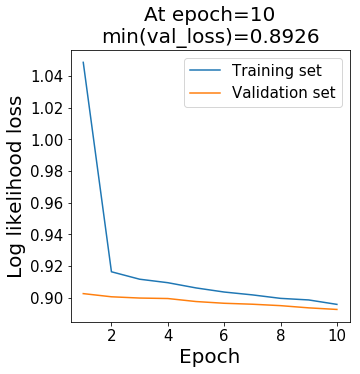

In [27]:
### Draw loss-plot

import scipy.stats
import matplotlib as mpl
mpl.rcParams["axes.labelsize"]=20
mpl.rcParams["xtick.labelsize"]=15
mpl.rcParams["ytick.labelsize"]=15
mpl.rcParams["legend.fontsize"]=15

c = 1
filepath="../checkpoints/"+conditions[c-1]+"/"

onlyloss = [f for f in listdir(filepath) if isfile(join(filepath, f))]
onlyloss = sorted([f for f in onlyloss if (".hdf5" in f)])

loss = np.zeros((len(onlyloss),3))
for indx,fl in enumerate(onlyloss):
    loss[indx,0] = fl[:-19]
    loss[indx,1] = fl[-18:-12]
    loss[indx,2] = fl[-11:-5]
loss.view('f8,f8,f8').sort(order=['f0'],axis=0)

plt.figure(figsize=(5,5))
plt.plot(loss[:,0],loss[:,1],label="Training set")
plt.plot(loss[:,0],loss[:,2],label="Validation set")
plt.xlabel("Epoch")
plt.ylabel("Log likelihood loss")
min_epoch, min_loss = min(enumerate(loss[:,2]), key=itemgetter(1))
plt.title("At epoch=%2d\nmin(val_loss)=%.4f" % (min_epoch+1, min_loss), size=20)
plt.legend(loc="upper right")

plt.show()

In [20]:
# Evaluate the trained CNN model by calculating the log likelihood loss of the test set
model.evaluate(test_lst[0],test_lst[c], verbose=1)

51069/51069 [==============================] - 4s 87us/step


0.8713548640236202

# Load the trained weights of CNN to analyze methylation patterns

In [24]:
# Construct the CNN model before loading the weights
filter_N = 80 # number of filters
hd_layer_N = 40 # number of neurons in the dense layer
droprate2 = 0.2 # droprate of the first dropout layer
droprate = 0.2 # droprate of the second dropout layer
input_shape2 = (5,201,1) # shape of inputs

inp2 = Input(shape=input_shape2)
conv2 = Conv2D(filter_N,kernel_size=(5,6),strides=(4,1),activation='relu',padding='valid')(inp2)
pool2 = MaxPooling2D(pool_size=(1,7),padding='valid')(conv2)
drop2 = Dropout(droprate2)(pool2)
flt2 = Flatten()(drop2)
dns = Dense(hd_layer_N, activation='relu')(flt2)
drop = Dropout(droprate)(dns)
outp = Dense(1, activation='sigmoid')(drop)
model = Model(inputs=inp2,outputs=outp)

# Load the trained weight
condition = "3A1-3L"
model.load_weights("./trained_weights_as_hdf5/%s.hdf5" % condition)
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=log_lkh_loss,optimizer=sgd)

In [25]:
# Get the predicted methylation rates of each CpG
model.predict(inout[0], verbose=1)

510698/510698 [==============================] - 43s 84us/step


array([[0.03142456],
       [0.03751135],
       [0.01962833],
       ...,
       [0.00616295],
       [0.02790747],
       [0.00929569]], dtype=float32)